In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from os import listdir,makedirs
from os.path import isfile,join
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
import statistics as st


test_dir = '/content/drive/MyDrive/CVPR/test'
catagories = []
for c in os.listdir(test_dir):
    catagories.append(c)
print(catagories)

['horse', 'airplane', 'deer', 'cat', 'automobile', 'ship', 'bird', 'truck', 'dog', 'frog']


In [9]:
from numpy.ma import test
test_data = []
for c in catagories:
    path = os.path.join(test_dir, c)
    label = catagories.index(c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img_arr, (32, 32))
        test_data.append([img_arr, label])

print(f"Total Test Data: {len(test_data)}")

100%|██████████| 1000/1000 [00:02<00:00, 363.76it/s]

Total Test Data: 10011


In [10]:
random.shuffle(test_data)

KFactor = [0.25, 0.5, 1, 2, 4]
kf = KFold(n_splits=5, random_state=None, shuffle=False)
for i,(train_index, test_index) in enumerate(kf.split(test_data)):
    k_values = np.multiply(np.sqrt(train_index.size),KFactor)
    # k_values = np.arange(1,np.sqrt(train_index.size)*10,40)
    k_values = [int(x) for x in k_values]
    break

In [11]:
accuracy = np.zeros((2,len(k_values),kf.n_splits), dtype=int)

res = []
for i,(train_index, test_index) in enumerate(kf.split(test_data)):
    for x in tqdm(test_index):
        r = []
        testData = test_data[x][0]
        l1 = []
        l2 = []
        for y in train_index:
            trainData = test_data[y][0]
            d = np.sum(abs(testData-trainData))
            l1.append(d)
            d = np.sqrt(np.sum((testData-trainData)**2))
            l2.append(d)
        l1_i = np.argsort(l1)
        l2_i = np.argsort(l2)
        for k in k_values:
            comp = []
            for j in l1_i[:k]:
                comp.append(test_data[j][1])
            if st.mode(comp) == test_data[x][1]:
                accuracy[0][k_values.index(k)][i] += 1
            comp = []
            for j in l2_i[:k]:
                comp.append(test_data[j][1])
            if st.mode(comp) == test_data[x][1]:
                accuracy[1][k_values.index(k)][i] += 1

100%|██████████| 2002/2002 [05:55<00:00,  5.62it/s]


In [12]:
L1_acc = [[],[]]
L2_acc = [[],[]]
print(accuracy)
for a in accuracy[0]:
    L1_acc[0].append(a.mean()*100/2000)
    L1_acc[1].append(a.std()*100/2000)
for a in accuracy[1]:
    L2_acc[0].append(a.mean()*100/2000)
    L2_acc[1].append(a.std()*100/2000)

[[[216 315 421 451 472]
  [220 338 424 443 471]
  [213 346 442 437 458]
  [205 340 393 411 450]
  [236 343 370 406 413]]

 [[186 265 273 303 318]
  [195 268 322 296 315]
  [207 248 310 306 320]
  [211 275 294 304 321]
  [207 288 288 298 331]]]


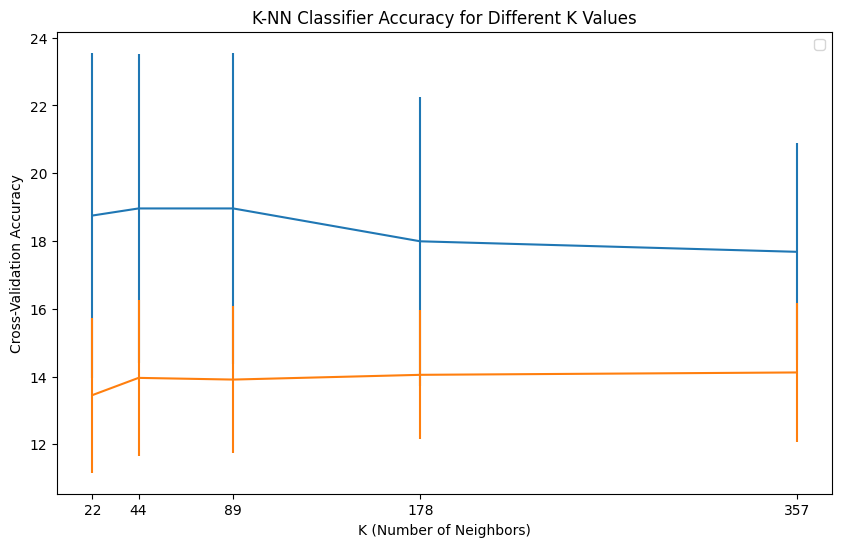

In [13]:
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, L1_acc[0], L1_acc[1])
plt.errorbar(k_values, L2_acc[0], L2_acc[1])
plt.legend(['Manhattan (L1)','Euclidean (L2)'])
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('K-NN Classifier Accuracy for Different K Values')
plt.xticks(k_values)
plt.legend()
plt.show()

Discussion:

Manhattan distance (L1 norm) measures how far apart two points are in a space with multiple dimensions, like in images. It's great for grayscale images because it captures the changes in pixel intensities, which help identify objects in the images. Euclidean distance (L2 norm), on the other hand, calculates the shortest distance between two points, considering both the size and direction of differences between them. This is useful when there are patterns or arrangements in the data.

Grayscale images have pixels with consistent values, making Manhattan distance a good choice. It works well when features have different scales. For images, where pixel values have a uniform scale, Manhattan distance is ideal.

To decide between Manhattan and Euclidean distance, think about the dataset's characteristics, the features, and how complicated the classes are. Both distances show similar patterns and can work well. The choice depends on the specific details of the data you're working with.